In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import const
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import re

In [2]:
### Fonction permettant l'extraction des couleurs principales d'une image selon méthode K-means

# Fonctions annexes
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def iqr(x):
    return q3(x) - q1(x) 

# Fonctions extraction K-means
def extract_colors_img_kmeans(file_path, nb_colors, without_bkg):
    """ Prend en argument :
        - le chemin de l'image
        - le nombre de couleurs à extraire
        - si l'image est détourée (True) ou non (False) 
            
    Retourne une liste contenant les indicateurs de position (moyenne, médiane, Q1, Q3) 
    et de dispersion (écart type et écart interquartile ) par couleur définies selon algorithme des K-means"""

    img = cv2.imread(file_path)

    # Taille image resizée
    img_width = 120
    img_height = 120

    # Nb de couleurs pour nettoyage image / érosion
    nb_colors_clean = 20

    # Resize image et affichage
    img_color = cv2.resize(img, dsize = (img_width,img_height)) 

    # Passage en noir et blanc et affichage
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    if without_bkg == True:

        # seuil érosion pour image détourée
        seuil_ero = 2

        # Erosion
        kernel = np.ones((4,4),np.uint8)
        erosion = cv2.erode(img_gray, kernel)

        erosion_gray = erosion.reshape(img_width*img_height, 1)
        erosion = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
        erosion = erosion.reshape(img_width*img_height, 3)

        # Application erosion à image en noir et blanc
        img_sort_gray = img_gray.reshape(img_width*img_height, 1)
        img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                                    (erosion[:,1] > seuil_ero) | 
                                    (erosion[:,2] > seuil_ero)]

        # Test découpage et ajustement seuil si besoin
        decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors_clean), axis=0))

        # Ajustement seuil érosion (5 maximum)
        # print(seuil_ero)
        while len(np.unique(decoup)) <= nb_colors_clean and seuil_ero<5:
            seuil_ero += 1
            img_sort_gray = img_gray.reshape(img_width*img_height, 1)
            img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                                    (erosion[:,1] > seuil_ero) | 
                                    (erosion[:,2] > seuil_ero)]
            decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors_clean), axis=0))
            # print(seuil_ero)

        # Exlusion des pixels totalement blancs (problème image)
        erosion[(erosion[:,0] > (255 - seuil_ero)) & 
                (erosion[:,1] > (255 - seuil_ero)) & 
                (erosion[:,2] > (255 - seuil_ero))] = 0

        # Application érosion sur image couleur
        img_sort_color = img_color.reshape(img_width*img_height, 3).copy()

        img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                        (erosion[:,1] > seuil_ero) |
                                        (erosion[:,2] > seuil_ero)]

        # Application érosion sur image noir et blanc
        img_sort_gray = img_gray.reshape(img_width*img_height, 1).copy()
        img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                                      (erosion[:,1] > seuil_ero) | 
                                      (erosion[:,2] > seuil_ero)]
    
    else:
        seuil_ero = 5

        # Exlusion des pixels totalement blancs (problème image)
        erosion = img_color.reshape(img_width*img_height, 3).copy()
        erosion[(erosion[:,0] > (255 - seuil_ero)) & 
                (erosion[:,1] > (255 - seuil_ero)) & 
                (erosion[:,2] > (255 - seuil_ero))] = 0

        # Application érosion sur image couleur
        img_sort_color = img_color.reshape(img_width*img_height, 3)

        img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                        (erosion[:,1] > seuil_ero) |
                                        (erosion[:,2] > seuil_ero)]

        # Application erosion à image en noir et blanc
        img_sort_gray = img_gray.reshape(img_width*img_height, 1)
        img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                                      (erosion[:,1] > seuil_ero) | 
                                      (erosion[:,2] > seuil_ero)]

    # Algorithme de K-means
    kmeans = KMeans(n_clusters = nb_colors)
    kmeans.fit(img_sort_color)

    # Centroids and labels
    # centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    labels.shape = (len(labels), 1)
    decoup_source = np.concatenate([img_sort_color, labels], axis = 1)

    # Passage en DataFrame
    df_img_gray = pd.DataFrame(img_sort_gray, columns=['Gray'])
    df_img_color = pd.DataFrame(decoup_source, columns=['B','G','R','Decoup'])

    df_img = pd.concat([df_img_gray, df_img_color], axis=1)

    calculs = {'R':['mean', 'std', 'median', q1, q3, iqr],
               'G':['mean', 'std', 'median', q1, q3, iqr],
               'B':['mean', 'std', 'median', q1, q3, iqr],
               'Gray':['mean', 'std', 'median', q1, q3, iqr],
               'Decoup':'count'}

    df_img_sort = df_img.groupby('Decoup', as_index=False).agg(calculs).round(1)

    df_img_sort = df_img_sort.set_axis(df_img_sort.columns.map('_'.join), axis=1)

    df_img_sort = df_img_sort.sort_values(by='Decoup_count', ascending=False)
    df_img_sort['Color'] = [f'C{i}' for i in range(1, nb_colors + 1)]

    # Passage des poids en %
    df_img_sort['poids_%'] = round((df_img_sort['Decoup_count'] / df_img_sort['Decoup_count'].sum())*100, 1)
    df_img_sort = df_img_sort.drop('Decoup_count', axis=1)
    df_img_sort = df_img_sort.set_index('Color')

    # Passage des informations en colonne pour chaque couleur
    rep_color_img = []
    for i in range(0, df_img_sort.shape[0]):
        if i == 0:
            rep_color_img = list(df_img_sort.iloc[i,-25:])
        else:
            rep_color_img.extend(list(df_img_sort.iloc[i,-25:]))

    return rep_color_img

In [3]:
def create_df_color_kmeans(dirDsPath, nb_colors, without_bkg=False):
    """ Prend en argument :
            - le dossier d'images à traiter
            - le nombre de couleurs à extraire par image
            - si l'image est détourée (True) ou non (False)
        
        Teste si le fichier csv correspondant existe déjà :
            - si présent, le charge, sinon le crée

        Retourne un DataFrame contenant les indicateurs de position (moyenne, médiane, Q1, Q3) 
        et de dispersion (écart type et écart interquartile ) par couleur définies 
        selon algorithme des K-means pour toutes les images du dossier """

    # Teste si le fichier texte correspondant existe déjà
    if without_bkg == False:
        filename = f'ML_maincolors_KM{nb_colors}.csv'
    else:
        filename = f'ML_maincolors_KM{nb_colors}_det.csv'
    
    ML_file_path = os.path.join(const.DATA_ML_PATH, filename)

    if not os.path.isfile(ML_file_path):
        print('Fichier non existant, création du fichier', '\n') 

        # Liste des échantillons à disposition
        ech = [setPath for setPath in os.listdir(dirDsPath)]

        # Initialisation
        l_img_coul = []

        for source in ech:
            #Chemin de l'échantillon
            path_ech = os.path.join(dirDsPath, source)

            # Parcourt les dossiers pour l'échantillon concerné (1 dossier = 1 classe)
            for folder in os.listdir(path_ech):
                # Chemin de la classe
                path_class = os.path.join(path_ech, folder)
                print(source, folder)
                
                # Parcourt les images à l'intérieur du dossier (classe)
                for items in os.listdir(path_class):
                    # Extraction informations couleurs de l'image
                    l_img_temp = extract_colors_img_kmeans(os.path.join(path_class, items), 
                                                    nb_colors, 
                                                    without_bkg)
                    
                    # Ajout des informations echantillon / classe / image
                    l_img_temp.extend([source, folder, items])

                    # Insertion à liste finale
                    l_img_coul.append(l_img_temp)

        # Création d'une liste contenant les libellés de colonne pour DF
        nom_col_df = []
        for d in range(1, nb_colors+1):
            for c in ['R', 'G', 'B', 'Gray']:
                for m in ['mean', 'std', 'median', 'q1', 'q3', 'iqr']:
                    nom_col_df.append(f'C{d}_KM_{c}_{m}')
            nom_col_df.append(f'Poids_{d}_%')
        nom_col_df.extend(['echantillon', 'classe', 'nom_img'])
        
        # Passage en dataframe
        df_maincolors_km = pd.DataFrame(l_img_coul, columns=nom_col_df)

        # sauvegarde du fichier
        df_maincolors_km.to_csv(ML_file_path, sep=',', header=True, index=True)

    else:
        print('Fichier existant, chargement à partir de ', '\n', const.DATA_PATH, '\\', filename, '\n')
        df_maincolors_km = pd.read_csv(ML_file_path, header=0, index_col=0, sep=',')
    
    return df_maincolors_km

In [4]:
### Fonction permettant de préparer les datasets pour machine learning
# Séparation des variables explicatives, des échantillons et normalisation des données à partir du 
# jeu d'entraînement

def sep_data(df, norm=True):
    """ Permet de préparer les datasets pour machine learning
        
        Prend en argument :
            - le DataFrame source
            - si les données sont à normaliser (True) ou non (False)

        Retourne dans l'ordre suivant :
            - X_train, y_train, X_test, y_test, X_valid, y_valid """
    
    # Affichage des quantités
    print("Quantité par échantillon :", '\n', df['echantillon'].value_counts(), '\n')

    # Séparation des variables explicatives de la cible selon leurs source (train, test, valid)
    y_train = df[df['echantillon'].str.lower()=='train']['classe']
    y_test = df[df['echantillon'].str.lower()=='test']['classe']
    y_valid = df[df['echantillon'].str.lower()=='valid']['classe']

    # Suppression de colonnes dans les features
    col_supr = ['echantillon', 'classe', 'nom_img']
    X_train = df[df['echantillon'].str.lower()=='train'].drop(col_supr, axis=1)
    X_test = df[df['echantillon'].str.lower()=='test'].drop(col_supr, axis=1)
    X_valid = df[df['echantillon'].str.lower()=='valid'].drop(col_supr, axis=1)

    if norm == True:
        # Normalisation des données
        # Instanciation du scaler
        scaler = StandardScaler().fit(X_train)

        # Application du scaler et conservation structure DataFrame
        for ds in [X_train, X_test, X_valid]:
            ds[ds.columns] = pd.DataFrame(scaler.transform(ds), index=ds.index)

    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [5]:
### Création classe pour réduction de dimensions

class Reduc_feat():
    """ Réduction de dimensions. 
        
        Prend en argument :
            - le dataset d'entraînement (ds_fit)
            - la liste des datasets de features à transformer (ds_transform)

        Utiliser les fonctions :
            - sup_var_null() pour supprimer les variables de variance nulle
            - print_acp() pour afficher les résultats de l'A.C.P 
            - exe_acp() pour éxécuter une A.C.P. """
    
    def __init__(self, ds_fit, ds_transform=[]):
        self.ds_fit = ds_fit
        self.ds_transform = ds_transform

    def sup_var_null(self, seuil=0.001):
        """ Pour supprimer les variables de variance nulle.
        
        Prend en argument :
            - le seuil de variance (par défaut 0.001) 
            
        Retourne les DataFrames contenus dans le paramètre ds_transform """

        # Recherche des features de variance nulle
        sel = VarianceThreshold(threshold = seuil)
        sel.fit(self.ds_fit)
        res = list(sel.get_support())
        print('Nombre de variable avec variance nulle : ', res.count(False))

        # Transformation des datasets si Nombre de variable avec variance nulle > 0
        if res.count(False) > 0:
            for i in range(0, len(self.ds_transform)):
                self.ds_transform[i] = pd.DataFrame(sel.transform(self.ds_transform[i]),
                                                index=self.ds_transform[i].index)
        
        return self.ds_transform
    
    def print_acp(self, nb_var_aff=50):
        """ Prend en argument le nombre de composantes à afficher pour graphiques (par défaut 50) """

        # Instanciation et entrainement ACP
        pca = PCA()
        pca.fit(self.ds_fit)

        # Affichage graphique
        fig = plt.figure(figsize=(15,7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
        ax1.set_xlim(0, nb_var_aff)
        ax1.set_xticks(range(0, nb_var_aff+1, nb_var_aff//12))
        ax1.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
        ax1.set_xlabel('nb composantes')
        ax1.set_ylabel('Part variance expliquée')
        ax1.set_title('Variance expliquée par Composante Principale')

        ax2.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
        ax2.set_xlabel('nb composantes')
        ax2.set_ylabel('Part variance expliquée')
        ax2.set_xlim(0, nb_var_aff)
        ax2.set_xticks(range(0, nb_var_aff+1, nb_var_aff//12))
        ax2.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
        ax2.set_title('Variance expliquée cumulée par Composante Principale')
        ax2.axhline(y=0.9, linestyle='--', color='black')
        plt.show()

        return self
    
    def exe_acp(self, nb_cp=0.9):
        """ Prend en argument le nombre de composantes à conserver ou le % (< à 1) de variance à 
        conserver (par défaut 0.9)

        Retourne la variance expliquée par composante et les DataFrames contenus dans le 
        paramètre ds_transform"""

        # Application aux différents jeux de données
        pca = PCA(n_components=nb_cp)
        pca.fit(self.ds_fit)

        nb_pca = pca.n_components_
        var_expl = pca.explained_variance_ratio_.cumsum()[nb_pca-1]

        print(f"""Part de la variance expliquée conservée pour {nb_pca} composantes : {var_expl:.2%}""")
        
        # pour nom colonnes
        nom_col = []
        for i in range(0, nb_pca):
            nom_col.append(f'CP{i+1}')

        for i in range(0, len(self.ds_transform)):
            self.ds_transform[i] = pd.DataFrame(pca.transform(self.ds_transform[i]),
                                                columns=nom_col, index=self.ds_transform[i].index)
        
        return self.ds_transform

In [6]:
### Fonction pour création de datasets train, test et valid pour un nombre de classes définies choisies 
# aléatoirement ou selon un noyeau défini

def sel_classe(nb_cl, ds_features=[], ds_target=[], noyau=None, representation=False):
    """ création de datasets pour un nombre de classes définies choisies aléatoirement 
    ou selon un noyau défini
    
    Prend en argument :
        - le nombre de classes souhaité (nb_cl)
        - la liste des dataframes des variables explicatives (ds_features / ordre train test valid)
        - la liste des dataframes de la variable cible (ds_target / ordre train test valid)
        - le noyau (facultatif)
        - la représentation graphique (representation=True) ou non (=False)

    Retourne dans l'ordre fourni par les listes :
        - ds_features et ds_target """
    
    # Pour sélection de n classes pour test
    classe = np.unique(ds_target[0].values)

    # Si noyeau défini
    if noyau != None:
        np.random.seed(noyau)
    
    # tirage aléatoire ou selon noyeau défini
    classe_test = np.random.choice(classe, size=nb_cl, replace=False)
    print('Classes sélectionnées : ', '\n', classe_test, '\n')

    # Extraction des classes parmi les dataframes des variables explicatives et de la variable cible
    ds_target_sel, ds_features_sel = [], []

    for i in range(0, len(ds_target)):
        ds_target_sel.append(ds_target[i][ds_target[i].isin(classe_test)])
        ds_features_sel.append(ds_features[i].loc[ds_target_sel[i].index])

    # Représentation des individus sur axe 1 et 2
    if representation == True:
        # Encodage y_train_sel pour graphique
        y_enc = ds_target_sel[0].replace(to_replace=classe_test, value=range(1, nb_cl+1))

        fig = plt.figure(figsize=(7, 5))
        ax1 = fig.add_subplot(111)
        ax1.scatter(ds_features_sel[0].iloc[:,0], ds_features_sel[0].iloc[:,1], c=y_enc, s=30)
        ax1.set_title("Données projetées sur les 2 premiers axes de l'ACP")
        ax1.set_xlabel('CP 1')
        ax1.set_ylabel('CP 2')
        plt.show()

    # Sortie
    ds_sort = ds_features_sel.copy()
    ds_sort.extend(ds_target_sel)
    return ds_sort

In [7]:
### Classe pour modélisation avec Régression logistique, Random Forest, Bagging et XGBoost

class Models():
    """ Modélisation et prédictions. 
        Utilisation de X_test / y_test pour test des hyper paramètres et X_valid / y_valid pour prédictions

        Prend en argument :
            - la liste des datasets de features et target 
                (ds / ordre X_train X_test X_valid y_train y_test y_valid)
            - Si l'on souhaite en sortie les prédictions obtenues sur valid (pred = True)

        Utiliser les fonctions :
            - modelisation() pour lancer les modélisations Régression logistique, 
                Random Forest, Bagging et XGBoost
            - reg_log() pour lancer 1 Régression logistique uniquement
            - rfc() pour lancer 1 Random Forest Classifier uniquement
            - bag() pour lancer 1 Bagging Classifier uniquement
            - ext_grad_boost() pour lancer EXtreme Gradient Boosting 
            
        Retourne :
            - Un dictionnaire avec modèle, meilleurs paramètres, score et prédictions sur valid 
            """
        
    def __init__(self, ds=[], pred=False):
        self.ds = ds
        self.sortie = {}
        self.pred = pred

        # Utilisation du set de test pour test paramètres et validation pour prédictions
        split_index = [-1]*len(self.ds[0]) + [0]*len(self.ds[1])
        self.X = np.concatenate((self.ds[0], self.ds[1]), axis=0)
        self.y = np.concatenate((self.ds[3], self.ds[4]), axis=0)
        self.pds = PredefinedSplit(test_fold = split_index)
        
        # Nombre de classes à prédire
        self.nb_cl = len(np.unique(self.ds[3].values))

        # Nombre maximum estimateurs
        self.nb_est_max = 1000

    def reg_log(self):
        # Définition paramètres
        params = {'penalty' : ['l1', 'l2', 'elasticnet', None],
                  'C': [0.01, 0.1, 0.2, 0.5, 1.0, 3.0],
                  'solver':['lbfgs', 'sag', 'saga']}

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid = GridSearchCV(estimator = LogisticRegression(n_jobs=-1), 
                                     cv=self.pds, param_grid=params, refit=True, n_jobs=-1)

        # Entrainement modèle
        grid.fit(self.X, self.y)

        # Résultats sur le jeu de test
        optimal_mdl = grid.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], self.ds[5]), 3)

        # Sortie
        if self.pred == True:
            y_pred = optimal_mdl.predict(self.ds[2])
            self.sortie = {'Reg Logistique': {'parametres' : grid.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'Reg Logistique': {'parametres' : grid.best_estimator_,
                                              'score' : res
                                              }
                            }
             
        return self.sortie
    
    def rfc(self):
        # Définition paramètres
        multipes = [5, 10] # Tests initiaux [1, 2, 5, 10, 20, 50]
        n_est = []

        if (self.nb_cl*0.06-2) < 1:
            coeff = 1
        else:
            coeff = (self.nb_cl*0.06-2)
        
        for multiple in multipes:
            if self.nb_cl * multiple <= (self.nb_est_max // coeff):
                 n_est.append(self.nb_cl * multiple)
            else :
                 if int((self.nb_est_max // coeff)) not in n_est:
                     n_est.append(int((self.nb_est_max // coeff)))
        
        params = {'n_estimators' : n_est,
                  'criterion' : ['entropy', 'log_loss'], # Tests initiaux ['gini', 'entropy', 'log_loss']
                  'max_features' : ['log2', None], # Tests initiaux ['sqrt', 'log2', None]
                  'max_depth' : [50],
                  'min_samples_split' : [2] }

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid = GridSearchCV(estimator = RandomForestClassifier(n_jobs=-1),
                            cv=self.pds, param_grid=params, refit=True, n_jobs=-1)

        # Entrainement modèle
        grid.fit(self.X, self.y)

        # Résultats sur le jeu de test
        optimal_mdl = grid.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], self.ds[5]), 3)

        # Sortie
        if self.pred == True:
            y_pred = optimal_mdl.predict(self.ds[2])
            self.sortie = {'Random Forest': {'parametres' : grid.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'Random Forest': {'parametres' : grid.best_estimator_,
                                              'score' : res
                                              }
                            }

        return self.sortie

    def bag(self):
        # Définition paramètres
        multipes = [1, 2, 5, 10, 20, 50]
        n_est = []
        if (self.nb_cl*0.06-1) < 1:
            coeff = 1
        else:
            coeff = (self.nb_cl*0.06-1)
        
        for multiple in multipes:
            if self.nb_cl * multiple <= (self.nb_est_max // coeff):
                 n_est.append(self.nb_cl * multiple)
            else :
                 if int((self.nb_est_max // coeff)) not in n_est:
                     n_est.append(int((self.nb_est_max // coeff)))
        
        params = {'n_estimators' : n_est}

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid = GridSearchCV(estimator = BaggingClassifier(n_jobs=-1),
                            cv=self.pds, param_grid=params, refit=True, n_jobs=-1)

        # Entrainement modèle
        grid.fit(self.X, self.y)

        # Résultats sur le jeu de test
        optimal_mdl = grid.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], self.ds[5]), 3)

        # Sortie
        if self.pred == True:
            y_pred = optimal_mdl.predict(self.ds[2])
            self.sortie = {'Bagging': {'parametres' : grid.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'Bagging': {'parametres' : grid.best_estimator_,
                                              'score' : res
                                              }
                            }

        return self.sortie

    def ext_grad_boost(self):

        # Encodage classe y_train_sel, y_test_sel, y_valid_sel pour format Matrix
        labelencoder = LabelEncoder()
        labelencoder.fit(self.ds[3].values)

        ds_enc=[]

        for enc, source in enumerate(range(3, 6)):
            ds_enc.insert(enc, pd.DataFrame(self.ds[source].values, columns=['classe'], 
                                            index=self.ds[source].index))
            ds_enc[enc]['classe_enc'] = labelencoder.transform(ds_enc[enc]['classe'])

        # Définition paramètres
        multipes = [20] # Tests initiaux [1, 2, 5, 10, 20, 50]
        n_est = []

        for multiple in multipes:
            if self.nb_cl * multiple <= self.nb_est_max:
                n_est.append(self.nb_cl * multiple)
            else :
                if self.nb_est_max not in n_est:
                    n_est.append(self.nb_est_max)

        params_xgb = {'n_estimators': n_est,
                      'learning_rate': [0.2],
                      # 'num_parallel_tree' : [2],
                      'device' : ['cuda'],
                      'tree_method' : ['gpu_hist'],
                      # 'updater' : ['grow_gpu_hist'],
                      # 'multi_strategy' : ['multi_output_tree'],
                      #'base_score' : [1/nb_cl],
                      # 'gamma' : [0.5, None],
                      'subsample' : [0.7],
                      'colsample_bytree' : [0.9],
                      # 'sampling_method' : ['gradient_based'],
                      'min_child_weight' : [0.8],
                      # 'grow_policy' :  ['lossguide'],
                      # 'max_depth' : [6, 12],
                      'eval_metric' : ['mlogloss'],
                      'early_stopping_rounds' : [20],
                      'n_jobs' : [-1]
                      }

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid_xgb = GridSearchCV(estimator = XGBClassifier(objective= 'softmax', num_class=self.nb_cl),
                                                        cv=self.pds, param_grid=params_xgb, 
                                                        refit=True, n_jobs=-1, scoring='accuracy')

        # Entrainement modèle
        y = np.concatenate((ds_enc[0]['classe_enc'], ds_enc[1]['classe_enc']), axis=0)
        grid_xgb.fit(self.X, y, eval_set=[(np.array(self.ds[0]), np.array(ds_enc[0]['classe_enc'])), 
                               (np.array(self.ds[1]), np.array(ds_enc[1]['classe_enc']))],
                               verbose=False)

        # Résultats sur le jeu de test
        optimal_mdl = grid_xgb.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], ds_enc[2]['classe_enc']), 3)

        # Sortie
        if self.pred == True:
            y_pred = labelencoder.inverse_transform(optimal_mdl.predict(self.ds[2]))
            self.sortie = {'XGBoost': {'parametres' : grid_xgb.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'XGBoost': {'parametres' : grid_xgb.best_estimator_,
                                              'score' : res
                                              }
                            }

        return self.sortie

    def classif(self):

        res_mdl1, res_mdl2, res_mdl3, res_mdl4 = {}, {}, {}, {}
        res_mdl1 = self.reg_log()
        print("regression logistique : ok")
        res_mdl2 = self.rfc()
        print("random forest classifier : ok")
        res_mdl3 = self.bag()
        print("bagging : ok")
        res_mdl4 = self.ext_grad_boost()
        print("Xgboost : ok", '\n')

        return res_mdl1, res_mdl2, res_mdl3, res_mdl4

In [8]:
# Jeux de données utilisés
print('Jeux de données utilisés :')
print('..\\data\\data_ML\\Test_ori')
print('..\\data\\data_ML\\Test_det', '\n')

# Environnement Machine Learning utilisé
print('Environnement Machine Learning utilisé :')
print(const.DATA_ML_PATH)

Jeux de données utilisés :
..\data\data_ML\Test_ori
..\data\data_ML\Test_det 

Environnement Machine Learning utilisé :
..\data\data_ML


Fichier existant, chargement à partir de  
 ..\data \ ML_maincolors_KM14.csv 


% valeurs manquantes totales : 0.000%

Quantité par échantillon : 
 echantillon
Train    1120
Test      240
Valid     240
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


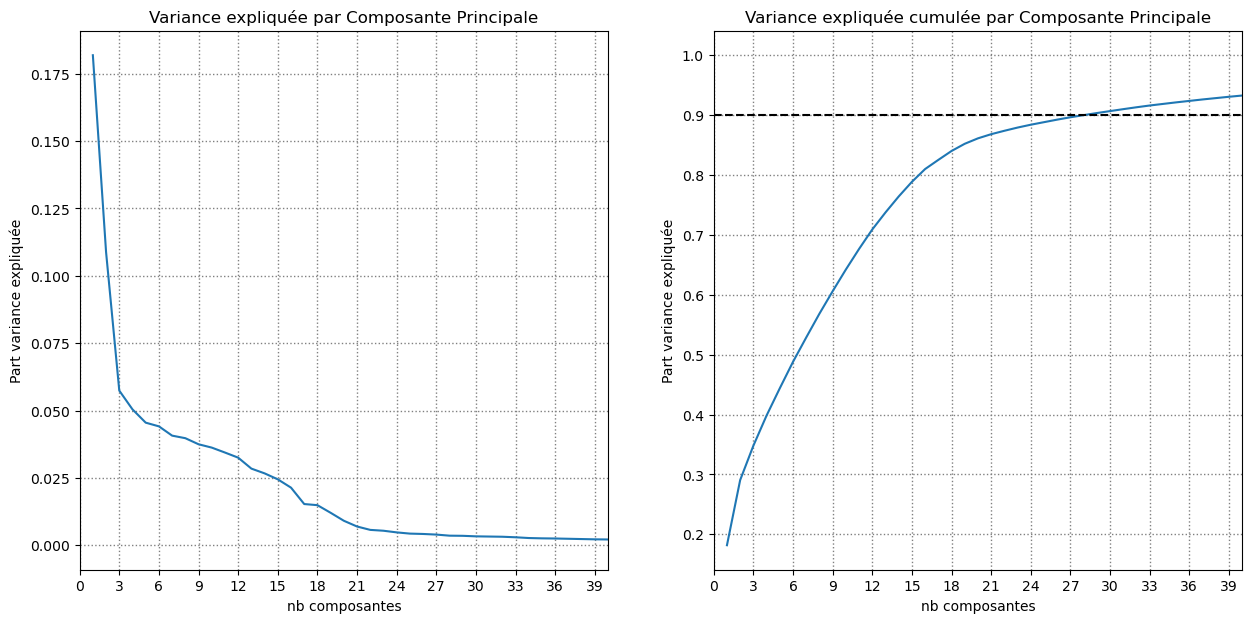

Part de la variance expliquée conservée pour 22 composantes : 87.38%


In [27]:
### Chargement des données, pré-processing et réduction des features pour images non détourées

# Création Dataframe à partir des données non détourées
df_maincolors_KM = create_df_color_kmeans('..\\data\\data_ML\\Test_ori', nb_colors=14, without_bkg=False)

# Test valeurs manquantes : devrait être OK avec correctif fonction extract_colors_img
print(f"""
% valeurs manquantes totales : {df_maincolors_KM.isna().sum(axis=0).sum()/
                                (df_maincolors_KM.shape[0]*df_maincolors_KM.shape[1]):.3%}
""")

# df_maincolors_KM['test_NA'] = df_maincolors_KM.isnull().sum(axis = 1)
# display(df_maincolors_KM)
# print(df_maincolors_KM[df_maincolors_KM['test_NA']>0][['echantillon','classe','nom_img','test_NA']])
# print(list(df_maincolors_KM.iloc[296, :]))

# Suppression valeurs manquantes en attendant nouveau dataset suite correctif fonction extract_colors_img
# df_maincolors_KM = df_maincolors_KM.dropna(axis = 0, how = 'any')

# Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# + normalisation
X_train, y_train, X_test, y_test, X_valid, y_valid = sep_data(df_maincolors_KM, norm=True)

# Recherche et suppression des variables de variance nulle
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).sup_var_null()

# Visualisation ACP
display(Reduc_feat(X_train, [X_train, X_test, X_valid]).print_acp(40))

# # Éxécution ACP
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).exe_acp(22)

Fichier existant, chargement à partir de  
 ..\data \ ML_maincolors_KM14_det.csv 


% valeurs manquantes totales : 0.002%

     echantillon                 classe  nom_img  test_NA
296        Train          ALPINE CHOUGH   19.jpg        4
299        Train          ALPINE CHOUGH   24.jpg        4
1463       Valid  FIRE TAILLED MYZORNIS  147.jpg        4 

Quantité par échantillon : 
 echantillon
Train    1120
Test      240
Valid     240
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


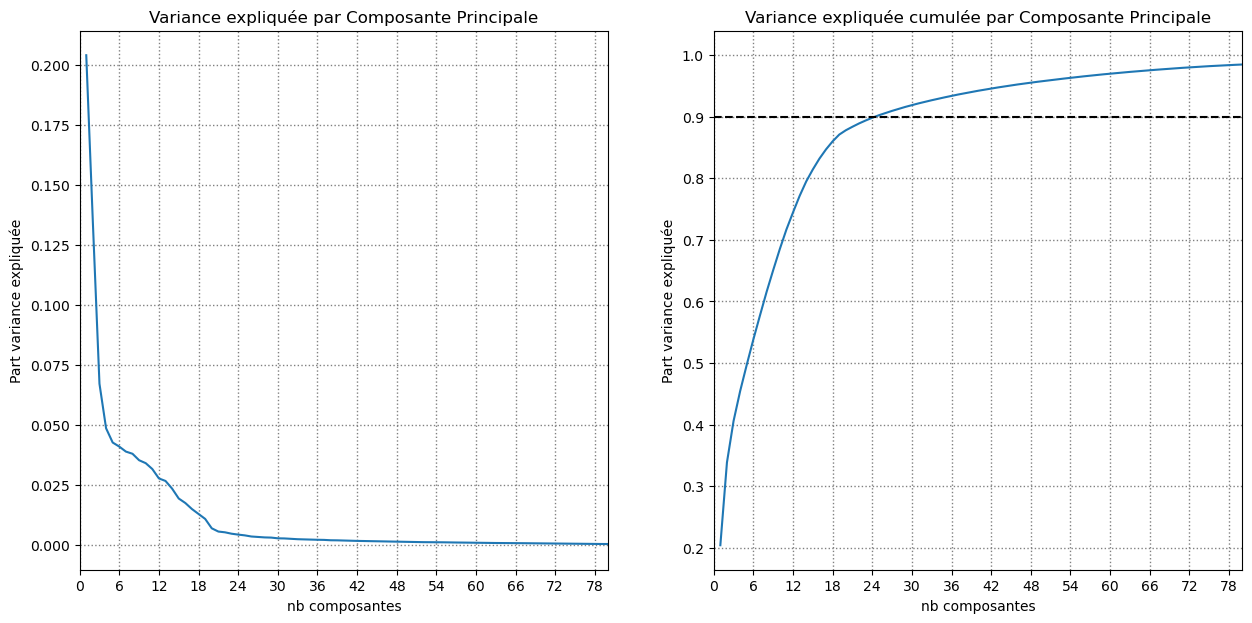

Part de la variance expliquée conservée pour 20 composantes : 87.81%


In [28]:
### Chargement des données, pré-processing et réduction des features pour images détourées

# Création Dataframe à partir des données détourées
df_maincolors_KM_det = create_df_color_kmeans('..\\data\\data_ML\\Test_det', nb_colors=14, without_bkg=True)

# Test valeurs manquantes : devrait être OK avec correctif fonction extract_colors_img
print(f"""
% valeurs manquantes totales : {df_maincolors_KM_det.isna().sum(axis=0).sum()/
                                (df_maincolors_KM_det.shape[0]*df_maincolors_KM_det.shape[1]):.3%}
""")

df_maincolors_KM_det['test_NA'] = df_maincolors_KM_det.isnull().sum(axis = 1)
# display(df_maincolors_KM_det)
print(df_maincolors_KM_det[df_maincolors_KM_det['test_NA']>0][['echantillon','classe','nom_img','test_NA']], '\n')

# Remplacement valeurs manquantes en attendant nouveau dataset suite correctif fonction extract_colors_img
df_maincolors_KM_det = df_maincolors_KM_det.fillna(0)

# Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# + normalisation
X_train_det, y_train_det, X_test_det, y_test_det, X_valid_det, y_valid_det = sep_data(df_maincolors_KM_det, 
                                                                                      norm=True)

# # Recherche et suppression des variables de variance nulle
X_train_det, X_test_det, X_valid_det = Reduc_feat(X_train_det, 
                                                  [X_train_det, X_test_det, X_valid_det]).sup_var_null()

# # Visualisation ACP
display(Reduc_feat(X_train_det, [X_train_det, X_test_det, X_valid_det]).print_acp(80))

# Éxécution ACP
X_train_det, X_test_det, X_valid_det = Reduc_feat(X_train_det, 
                                                  [X_train_det, X_test_det, X_valid_det]).exe_acp(20)

,R_mean,R_std,R_median,R_q1,R_q3,R_iqr,G_mean,G_std,G_median,G_q1,...,B_q1,B_q3,B_iqr,Gray_mean,Gray_std,Gray_median,Gray_q1,Gray_q3,Gray_iqr,poids_%
Color,,,,,,,,,,,,,,,,,,,,,
C1,72.6,6.0,73.0,68.0,77.0,9.0,98.3,7.8,99.0,94.0,...,50.0,60.0,10.0,85.7,5.1,86.0,82.0,90.0,8.0,17.1
C2,45.1,6.1,44.0,41.0,48.0,7.0,59.0,8.9,59.0,52.0,...,26.0,36.0,10.0,51.6,5.7,52.0,47.0,56.0,9.0,16.2
C3,57.6,7.8,57.0,51.0,63.0,12.0,72.5,6.5,73.0,68.0,...,42.0,50.0,8.0,65.0,4.8,65.0,61.0,69.0,8.0,13.7
C4,75.5,7.3,74.0,71.0,79.0,8.0,110.0,7.4,108.0,105.0,...,19.5,34.5,15.0,90.2,6.6,89.0,86.0,94.0,8.0,12.5
C5,88.9,8.4,87.0,83.0,93.0,10.0,113.6,7.7,114.0,109.0,...,57.0,70.0,13.0,100.6,5.5,100.0,97.0,104.0,7.0,12.1
C6,60.5,6.3,60.0,56.0,65.0,9.0,92.4,7.1,94.0,87.0,...,33.0,40.5,7.5,76.4,5.8,77.0,73.0,81.0,8.0,10.2
C7,28.4,12.1,30.5,20.0,36.0,16.0,31.2,9.6,33.5,25.0,...,17.0,24.0,7.0,29.2,8.3,31.0,24.0,36.0,12.0,9.7
C8,96.1,11.0,94.0,89.0,101.0,12.0,91.1,8.8,92.0,85.0,...,37.0,49.0,12.0,87.1,6.7,88.0,83.0,92.0,9.0,4.6
C9,111.2,16.6,109.0,103.0,113.0,10.0,150.2,14.7,148.5,140.8,...,47.8,75.2,27.5,128.4,15.3,124.5,119.0,133.2,14.2,2.3


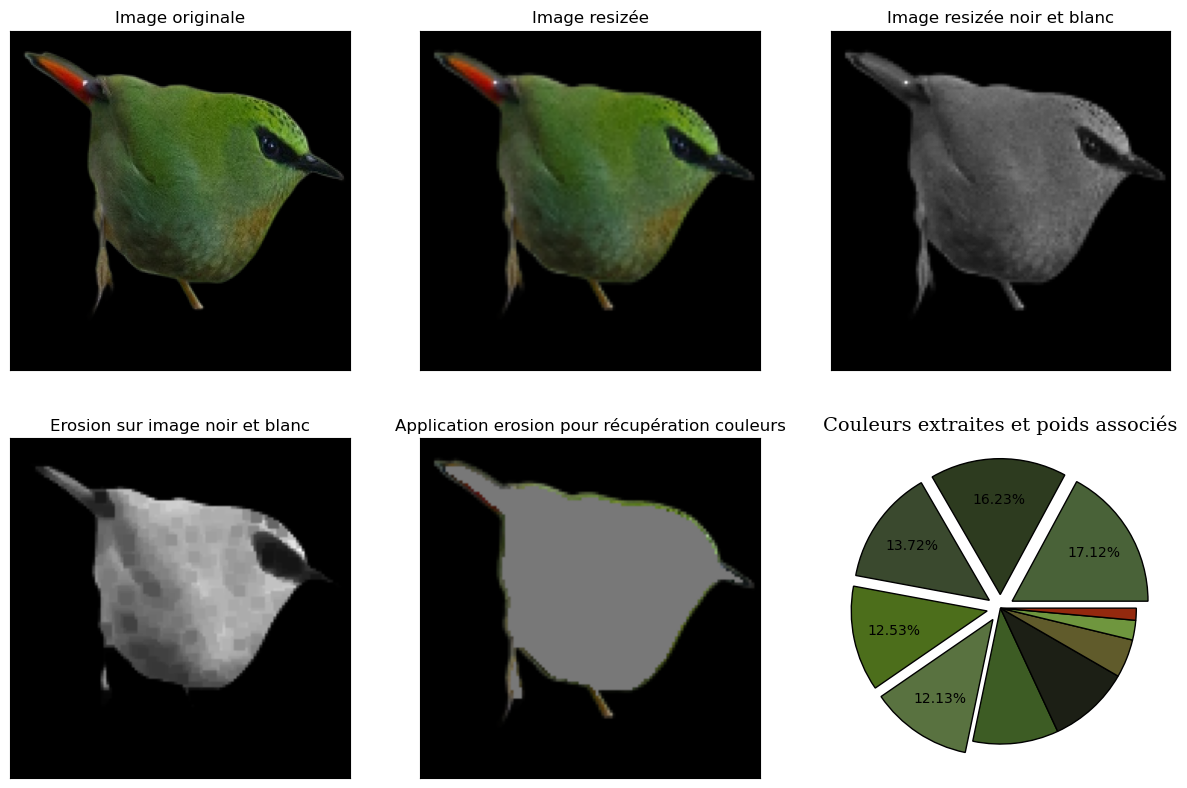

In [11]:
### Démo complète pour images détourées

## Images "spéciales" (avec valeurs manquantes)
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BULWERS PHEASANT\\55.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\LAUGHING GULL\\209.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\WALL CREAPER\\147.JPG')

## Images pas ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN PIED HORNBILL\\164.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\45.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ASIAN CRESTED IBIS\\126.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ALPINE CHOUGH\\42.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BUSH TURKEY\\17.JPG')

## Images ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\valid\\FIRE TAILLED MYZORNIS\\147.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN FLAMINGO\\27.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\69.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\1.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\134.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\CROW\\20.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN EMERALD CUCKOO\\114.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\YELLOW BREASTED CHAT\\60.JPG')


# Taille image resizée
img_width = 120
img_height = 120

# seuil érosion
seuil_ero = 2

# Nb de couleurs souhaitées dans palette
nb_colors_clean = 20
nb_colors = 10

# Affichage image originale
plt.figure(figsize = (15,15))
plt.subplot(331)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

# Resize image et affichage
img_color = cv2.resize(img, dsize = (img_width,img_height)) 

plt.subplot(332)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image resizée')

# Passage en noir et blanc et affichage
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
plt.subplot(333)
plt.imshow(img_gray, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Image resizée noir et blanc')

# Erosion et affichage
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(img_gray, kernel)
plt.subplot(334)
plt.imshow(erosion, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Erosion sur image noir et blanc')

erosion_gray = erosion.reshape(img_width*img_height, 1)
erosion = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
erosion = erosion.reshape(img_width*img_height, 3)

# Application erosion à image en noir et blanc
img_sort_gray = img_gray.reshape(img_width*img_height, 1)
img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]

# Test découpage et ajustement seuil si besoin
decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors_clean), axis=0))

# Ajustement seuil érosion (5 maximum)
# print(seuil_ero)
while len(np.unique(decoup)) <= nb_colors_clean and seuil_ero<5:
    seuil_ero += 1
    img_sort_gray = img_gray.reshape(img_width*img_height, 1)
    img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]
    decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors_clean), axis=0))
    # print(seuil_ero)

# Exlusion des pixels totalement blancs (problème image)
erosion[(erosion[:,0] > (255 - seuil_ero)) & 
        (erosion[:,1] > (255 - seuil_ero)) & 
        (erosion[:,2] > (255 - seuil_ero))] = 0

# Application érosion sur image couleur
img_sort_color = img_color.reshape(img_width*img_height, 3).copy()

img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                (erosion[:,1] > seuil_ero) |
                                (erosion[:,2] > seuil_ero)]

# Application érosion sur image couleur pour affichage
img_color_sel = img_color.reshape(img_width*img_height, 3).copy()
img_color_sel[(erosion[:,0] > seuil_ero) | (erosion[:,1] > seuil_ero) | (erosion[:,2] > seuil_ero)] = 120
img_color_sel = img_color_sel.reshape(img_width, img_height, 3)

plt.subplot(335)
plt.imshow(cv2.cvtColor(img_color_sel, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Application erosion pour récupération couleurs')

# Algorithme de K-means
kmeans = KMeans(n_clusters = nb_colors)
kmeans.fit(img_sort_color)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# print(type(labels), labels, np.unique(labels), labels.shape)

labels.shape = (len(labels), 1)
decoup_source = np.concatenate([img_sort_color, labels], axis = 1)

# Passage en DataFrame
df_img_gray = pd.DataFrame(img_sort_gray, columns=['Gray'])
df_img_color = pd.DataFrame(decoup_source, columns=['B','G','R','Decoup'])

df_img = pd.concat([df_img_gray, df_img_color], axis=1)

# Calcul des indicateurs
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def iqr(x):
    return q3(x) - q1(x) 

calculs = {'R':['mean', 'std', 'median', q1, q3, iqr],
           'G':['mean', 'std', 'median', q1, q3, iqr],
           'B':['mean', 'std', 'median', q1, q3, iqr],
           'Gray':['mean', 'std', 'median', q1, q3, iqr],
           'Decoup':'count'}

df_img_sort = df_img.groupby('Decoup', as_index=False).agg(calculs).round(1)

# df_img_sort.columns = ['_'.join(col) for col in df_img_sort.columns.values]
df_img_sort = df_img_sort.set_axis(df_img_sort.columns.map('_'.join), axis=1)

df_img_sort = df_img_sort.sort_values(by='Decoup_count', ascending=False)
df_img_sort['Color'] = [f'C{i}' for i in range(1, nb_colors + 1)]

colors = []
explode = []
for i in range(0, nb_colors):
    nt = (df_img_sort.iloc[i,0] / 255, df_img_sort.iloc[i,6] / 255, df_img_sort.iloc[i,12] / 255)
    colors.append(nt)
    if i <= 4:
        explode.append(0.1)
    else:
        explode.append(0)

# print(colors[1], type(colors[1]))

ax = plt.subplot(336)
ax.pie(df_img_sort['Decoup_count'], # labels=df_img_sort['Color'],
        colors=colors, 
        explode=explode,
        labeldistance=0.7,
        autopct=lambda v: f'{v:.2f}%' if v > 11 else None,
        pctdistance=0.7,
        wedgeprops={"edgecolor":"k",'linewidth': 1})
titre = ax.set_title("Couleurs extraites et poids associés")
titre.set(color="black", fontsize="14", fontfamily="serif")

# Passage des poids en %
df_img_sort['poids_%'] = round((df_img_sort['Decoup_count'] / df_img_sort['Decoup_count'].sum())*100, 1)
df_img_sort = df_img_sort.drop('Decoup_count', axis=1)
df_img_sort = df_img_sort.set_index('Color')

# df_img_sort.to_csv('..\\data\\data_ML\\test_kmeans.csv', sep=',', header=True, index=True)
display(df_img_sort)

rep_color_img = []
# # Passage des informations en colonne pour chaque couleur
for i in range(0, df_img_sort.shape[0]):
#     # print(list(df_img_sort.iloc[i,-20:]))
    if i == 0:
        rep_color_img = list(df_img_sort.iloc[i,-25:])
    else:
        rep_color_img.extend(list(df_img_sort.iloc[i,-25:]))

,decoup_,R_mean,G_mean,B_mean,Poids_%
0,C1,250.3,249.9,250.8,34.0
1,C2,14.6,14.4,15.9,29.0
2,C3,32.7,34.1,41.9,10.1
3,C4,226.1,223.5,228.3,7.4
4,C5,194.9,192.2,195.4,5.7
5,C6,166.0,162.9,164.7,5.3
6,C7,140.0,135.8,135.7,3.9
7,C8,104.5,99.4,97.3,2.0
8,C9,49.6,140.7,228.6,1.5
9,C10,36.0,88.2,172.4,1.1


[None, None, None]

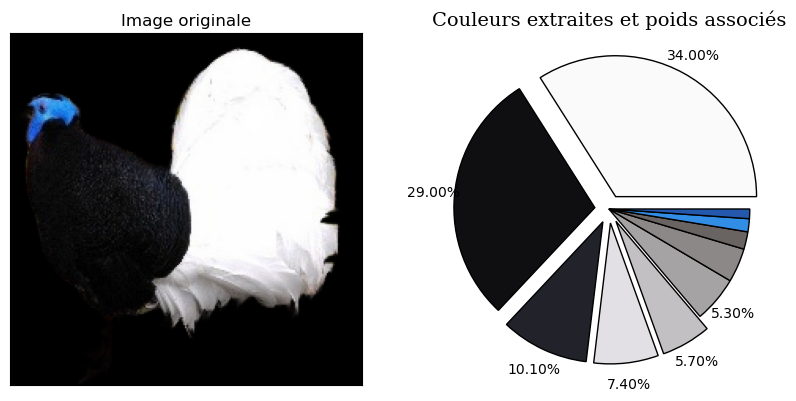

In [12]:
### Test fonction extract_colors_img_kmeans

# Image détourée
without_bkg = True
path = '..\\data\\dataset_birds_test_wo_background\\train\\BULWERS PHEASANT\\55.JPG'
# path = '..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN FLAMINGO\\27.JPG'

# Image originale (non détourée)
# without_bkg = False
# path = '..\\data\\dataset_birds_test\\test\\ALPINE CHOUGH\\6.JPG'
# path = '..\\data\\dataset_birds_test\\test\\ALBERTS TOWHEE\\32.JPG'
# path = '..\\data\\dataset_birds_test\\train\\AMERICAN FLAMINGO\\27.JPG'
# path = '..\\data\\\dataset_birds_test\\test\AMERICAN AVOCET\\69.JPG'
# path = '..\\data\\dataset_birds_test\\test\\ABBOTTS BABBLER\\1.JPG'

nb_colors = 10
res = extract_colors_img_kmeans(path, nb_colors, without_bkg=without_bkg)

# print(len(res), res)
# Récupération données
recup_res = []
for num, i in enumerate(range(0, len(res), 25)):
    # print(num, i, i+6, i+12)
    # print(num, res[i], res[i+6], res[i+12])
    recup_res.append([f'C{num+1}', res[i], res[i+6], res[i+12], res[i+24]])

df_img_sort = pd.DataFrame(recup_res, columns=['decoup_', 'R_mean', 'G_mean', 'B_mean', 'Poids_%'])

display(df_img_sort)
colors = []
explode = []
for i in range(0, nb_colors):
    nt = (df_img_sort.iloc[i,1] / 255, df_img_sort.iloc[i,2] / 255, df_img_sort.iloc[i,3] / 255)
    colors.append(nt)
    if i <= 4:
        explode.append(0.1)
    else:
        explode.append(0)

# # print(colors[1], type(colors[1]))

plt.figure(figsize=(10,5))

# Image originale
img = cv2.imread(path)
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

# Extraction couleur K-means
ax = plt.subplot(122)
ax.pie(df_img_sort['Poids_%'], # labels=df_img_sort['Color'],
        colors=colors, 
        explode=explode,
        labeldistance=0.7,
        autopct=lambda v: f'{v:.2f}%' if v > 5 else None,
        pctdistance=1.15,
        wedgeprops={"edgecolor":"k",'linewidth': 1})
titre = ax.set_title("Couleurs extraites et poids associés")
titre.set(color="black", fontsize="14", fontfamily="serif")

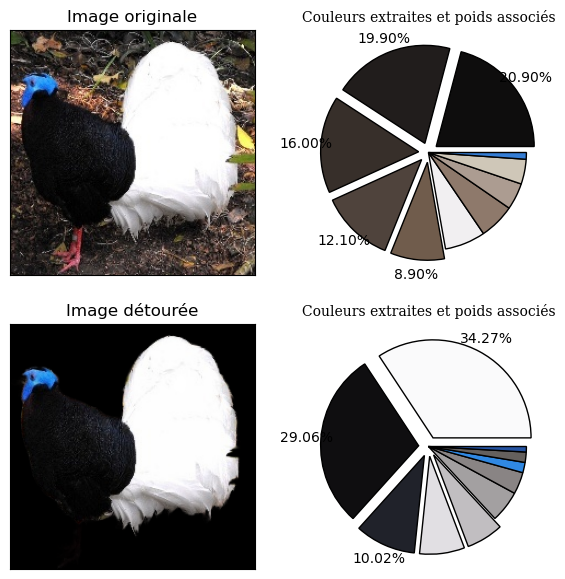

In [13]:
### Illustration écart entre image origine et détourée

## Images non détourées
without_bkg_ori = False
# path_ori = '..\\data\\dataset_birds_test\\train\\ALEXANDRINE PARAKEET\\41.JPG'
path_ori = '..\\data\\dataset_birds_test\\train\\BULWERS PHEASANT\\55.JPG'

## Images détourées
without_bkg_det = True
# path_det = '..\\data\\dataset_birds_test_wo_background\\test\\ALEXANDRINE PARAKEET\\41.JPG'
path_det = '..\\data\\dataset_birds_test_wo_background\\train\\BULWERS PHEASANT\\55.JPG'

nb_colors = 10
res_ori = extract_colors_img_kmeans(path_ori, nb_colors, without_bkg=without_bkg_ori)
res_det = extract_colors_img_kmeans(path_det, nb_colors, without_bkg=without_bkg_det)

# Récupération données
recup_res_ori = []
for num, i in enumerate(range(0, len(res_ori), 25)):
    # print(num, i, i+6, i+12)
    # print(num, res[i], res[i+6], res[i+12])
    recup_res_ori.append([f'C{num+1}', res_ori[i], res_ori[i+6], res_ori[i+12], res_ori[i+24]])

df_img_sort_ori = pd.DataFrame(recup_res_ori, columns=['decoup_', 'R_mean', 'G_mean', 'B_mean', 'Poids_%'])

# display(df_img_sort)
colors_ori = []
explode_ori = []
for i in range(0, nb_colors):
    nt = (df_img_sort_ori.iloc[i,1] / 255, df_img_sort_ori.iloc[i,2] / 255, df_img_sort_ori.iloc[i,3] / 255)
    colors_ori.append(nt)
    if i <= 4:
        explode_ori.append(0.1)
    else:
        explode_ori.append(0)

recup_res_det = []
for num, i in enumerate(range(0, len(res_det), 25)):
    # print(num, i, i+6, i+12)
    # print(num, res[i], res[i+6], res[i+12])
    recup_res_det.append([f'C{num+1}', res_det[i], res_det[i+6], res_det[i+12], res_det[i+24]])

df_img_sort_det = pd.DataFrame(recup_res_det, columns=['decoup_', 'R_mean', 'G_mean', 'B_mean', 'Poids_%'])

# display(df_img_sort)
colors_det = []
explode_det = []
for i in range(0, nb_colors):
    nt = (df_img_sort_det.iloc[i,1] / 255, df_img_sort_det.iloc[i,2] / 255, df_img_sort_det.iloc[i,3] / 255)
    colors_det.append(nt)
    if i <= 4:
        explode_det.append(0.1)
    else:
        explode_det.append(0)

# # print(colors[1], type(colors[1]))

plt.figure(figsize=(7,7))

# Image originale
img = cv2.imread(path_ori)
plt.subplot(221)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

# Extraction couleur K-means
ax = plt.subplot(222)
ax.pie(df_img_sort_ori['Poids_%'], # labels=df_img_sort['Color'],
        colors=colors_ori, 
        explode=explode_ori,
        labeldistance=0.7,
        autopct=lambda v: f'{v:.2f}%' if v > 8 else None,
        pctdistance=1.15,
        wedgeprops={"edgecolor":"k",'linewidth': 1})
titre = ax.set_title("Couleurs extraites et poids associés")
titre.set(color="black", fontsize="10", fontfamily="serif")

# Image détourée
img = cv2.imread(path_det)
plt.subplot(223)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image détourée')

# Extraction couleur K-means
ax = plt.subplot(224)
ax.pie(df_img_sort_det['Poids_%'], # labels=df_img_sort['Color'],
        colors=colors_det, 
        explode=explode_det,
        labeldistance=0.7,
        autopct=lambda v: f'{v:.2f}%' if v > 10 else None,
        pctdistance=1.15,
        wedgeprops={"edgecolor":"k",'linewidth': 1})
titre = ax.set_title("Couleurs extraites et poids associés")
titre.set(color="black", fontsize="10", fontfamily="serif")

plt.show()

In [14]:
""" Séquence de tests : code non optimisé """

' Séquence de tests : code non optimisé '

In [29]:
# Initialisation résultats de l'ensemble des tests
res_ml = []
ML_file_path_res = '..\\data\\data_ML\\Test_mdl_Kmeans.csv'

ds_KM = [X_train, X_test, X_valid, y_train, y_test, y_valid]
ds_KM_det = [X_train_det, X_test_det, X_valid_det, y_train, y_test, y_valid]

In [30]:
### 1. Test modèles sur images originales : source de données KMeans

classes = np.unique(ds_KM[3].values)

res_log, res_rfc, res_bag, res_xgb = Models(ds_KM).classif()
res_classif = [res_log, res_rfc, res_bag, res_xgb]

mdl_classif = ['Reg Logistique', 'Random Forest', 'Bagging', 'XGBoost']

base = '1. Originale'
source = '3. K-means'

# liste des classes sélectionnées
classe_sel = ''
for i, cl in enumerate(classes):
    if i == 0:
        classe_sel = cl
    else:
        classe_sel = classe_sel + ', ' + cl

for mdl, res in zip(mdl_classif, res_classif):
    # Enregistrement du contexte du modèle
    res_mdl = []
    res_mdl.append(base)
    res_mdl.append(source)
    res_mdl.append(len(classes))
    res_mdl.append(classe_sel)
    res_mdl.append(mdl)
    # Enregistrement des paramètres et du score du modèle
    param = list(res[mdl].values())[0]
    param = f'{param}'                  # Passage en string
    param = re.sub('\s+', ' ', param)   # Suppression des tabulsations, retour à la ligne, ...
    res_score = list(res[mdl].values())[1]
    res_mdl.append(param)
    res_mdl.append(res_score)
    # Ajout à la liste finale
    res_ml.append(res_mdl)

print(len(res_ml))
print("base : ", base, "source : ", source)

regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

4
base :  1. Originale source :  3. K-means


(1600, 315)
['ALPINE CHOUGH' 'BLACK VENTED SHEARWATER' 'BROWN THRASHER'
 'CERULEAN WARBLER' 'FIRE TAILLED MYZORNIS' 'INCA TERN' 'INDIAN PITTA'
 'JOCOTOCO ANTPITTA' 'PARAKETT AUKLET' 'VEERY']
Quantité par échantillon : 
 echantillon
train    1120
test      240
valid     240
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


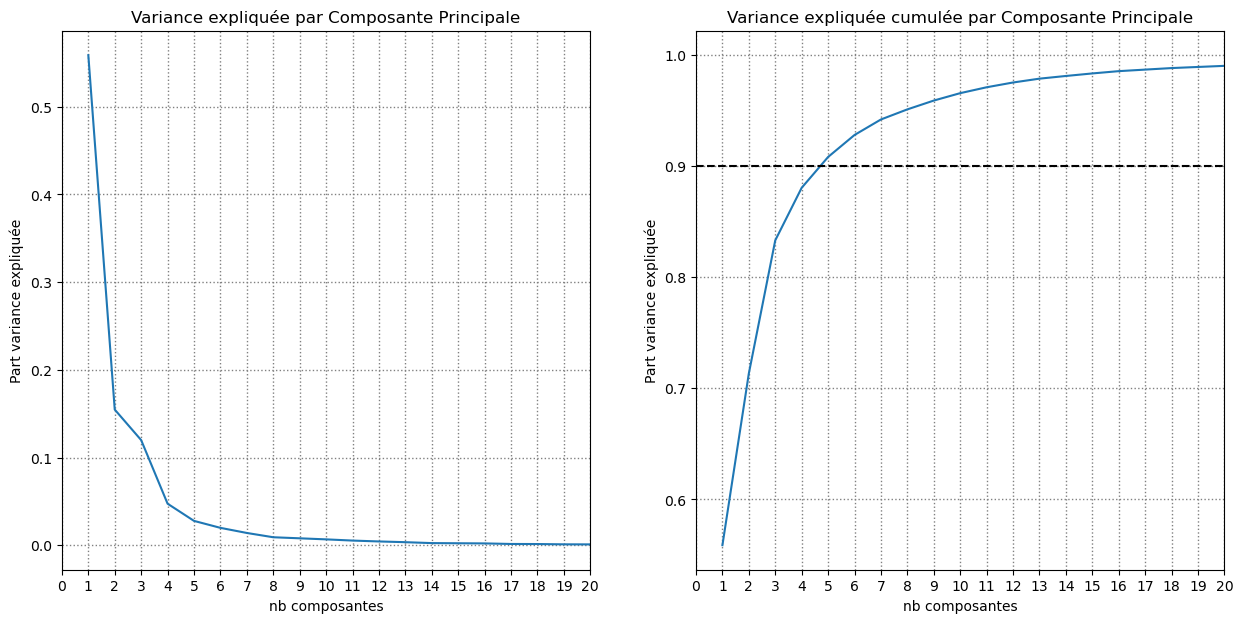

Part de la variance expliquée conservée pour 11 composantes : 97.11%
regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

8
base :  1. Originale source :  1. Intensité


In [31]:
### 2. Test modèles sur images originales : source de données Intensité (ML_01)

## Import fichier
ML_file_path = os.path.join(const.DATA_ML_PATH, 'ML_rep100_BGR.csv')
df_rep100_BGR = pd.read_csv(ML_file_path, header=0, index_col=0, sep=',')

## Sélection des 10 classes testées pour K-means
df_rep100_BGR = df_rep100_BGR[df_rep100_BGR['classe'].isin(classes)]

print(df_rep100_BGR.shape)
print(np.unique(df_rep100_BGR['classe']))

## Traitements "classiques"

# Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# + normalisation
X_train, y_train, X_test, y_test, X_valid, y_valid = sep_data(df_rep100_BGR, norm=True)

# Recherche et suppression des variables de variance nulle
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).sup_var_null()

# Visualisation ACP
display(Reduc_feat(X_train, [X_train, X_test, X_valid]).print_acp(20))

# Éxécution ACP
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).exe_acp(11)

## Modélisation
ds_ML1 = [X_train, X_test, X_valid, y_train, y_test, y_valid]

classes = np.unique(ds_ML1[3].values)

res_log, res_rfc, res_bag, res_xgb = Models(ds_ML1).classif()
res_classif = [res_log, res_rfc, res_bag, res_xgb]

mdl_classif = ['Reg Logistique', 'Random Forest', 'Bagging', 'XGBoost']

base = '1. Originale'
source = '1. Intensité'

# liste des classes sélectionnées
classe_sel = ''
for i, cl in enumerate(classes):
    if i == 0:
        classe_sel = cl
    else:
        classe_sel = classe_sel + ', ' + cl

for mdl, res in zip(mdl_classif, res_classif):
    # Enregistrement du contexte du modèle
    res_mdl = []
    res_mdl.append(base)
    res_mdl.append(source)
    res_mdl.append(len(classes))
    res_mdl.append(classe_sel)
    res_mdl.append(mdl)
    # Enregistrement des paramètres et du score du modèle
    param = list(res[mdl].values())[0]
    param = f'{param}'                  # Passage en string
    param = re.sub('\s+', ' ', param)   # Suppression des tabulsations, retour à la ligne, ...
    res_score = list(res[mdl].values())[1]
    res_mdl.append(param)
    res_mdl.append(res_score)
    # Ajout à la liste finale
    res_ml.append(res_mdl)

print(len(res_ml))
print("base : ", base, "source : ", source)

(1600, 483)
['ALPINE CHOUGH' 'BLACK VENTED SHEARWATER' 'BROWN THRASHER'
 'CERULEAN WARBLER' 'FIRE TAILLED MYZORNIS' 'INCA TERN' 'INDIAN PITTA'
 'JOCOTOCO ANTPITTA' 'PARAKETT AUKLET' 'VEERY']
Quantité par échantillon : 
 echantillon
train    1120
test      240
valid     240
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


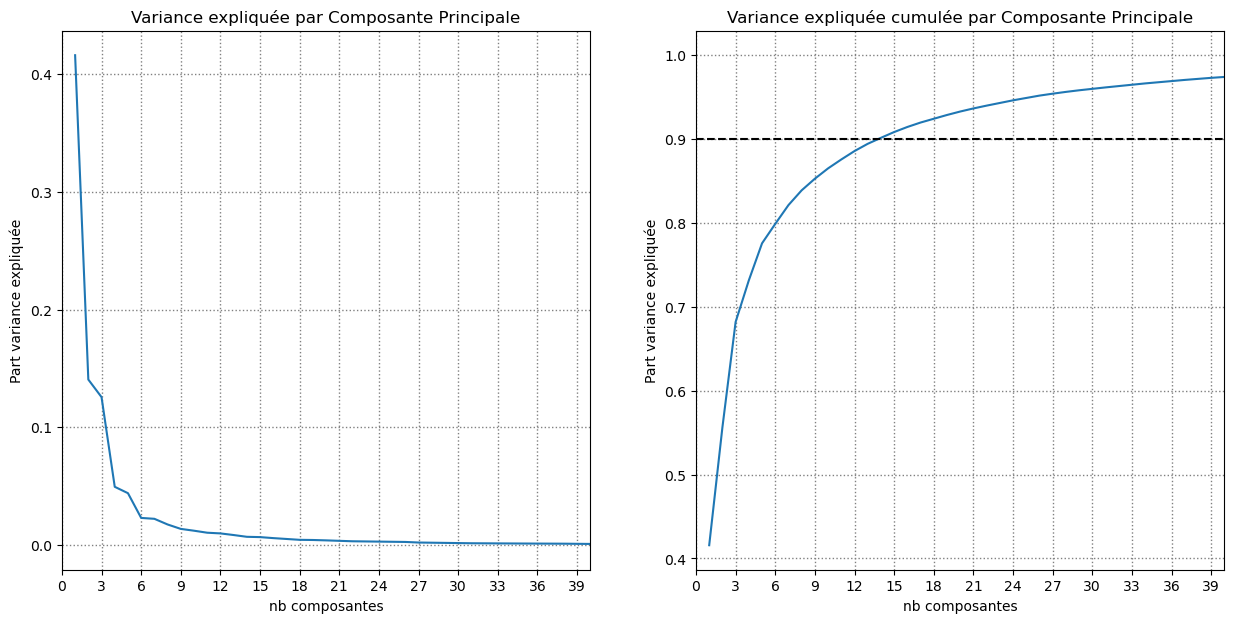

Part de la variance expliquée conservée pour 20 composantes : 93.29%
regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

12
base :  1. Originale source :  2. Couleurs


In [32]:
### 3. Test modèles sur images originales : source de données Palette couleurs (ML_02)

## Import fichier
ML_file_path = os.path.join(const.DATA_ML_PATH, 'ML_maincolors20.csv')
df_maincolors = pd.read_csv(ML_file_path, header=0, index_col=0, sep=',')

## Sélection des 10 classes testées pour K-means
df_maincolors = df_maincolors[df_maincolors['classe'].isin(classes)]

print(df_maincolors.shape)
print(np.unique(df_maincolors['classe']))

## Traitements "classiques"

# Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# + normalisation
X_train, y_train, X_test, y_test, X_valid, y_valid = sep_data(df_maincolors, norm=True)

# Recherche et suppression des variables de variance nulle
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).sup_var_null()

# Visualisation ACP
display(Reduc_feat(X_train, [X_train, X_test, X_valid]).print_acp(40))

# Éxécution ACP
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).exe_acp(20)

## Modélisation
ds_ML2 = [X_train, X_test, X_valid, y_train, y_test, y_valid]

classes = np.unique(ds_ML2[3].values)

res_log, res_rfc, res_bag, res_xgb = Models(ds_ML2).classif()
res_classif = [res_log, res_rfc, res_bag, res_xgb]

mdl_classif = ['Reg Logistique', 'Random Forest', 'Bagging', 'XGBoost']

base = '1. Originale'
source = '2. Couleurs'

# liste des classes sélectionnées
classe_sel = ''
for i, cl in enumerate(classes):
    if i == 0:
        classe_sel = cl
    else:
        classe_sel = classe_sel + ', ' + cl

for mdl, res in zip(mdl_classif, res_classif):
    # Enregistrement du contexte du modèle
    res_mdl = []
    res_mdl.append(base)
    res_mdl.append(source)
    res_mdl.append(len(classes))
    res_mdl.append(classe_sel)
    res_mdl.append(mdl)
    # Enregistrement des paramètres et du score du modèle
    param = list(res[mdl].values())[0]
    param = f'{param}'                  # Passage en string
    param = re.sub('\s+', ' ', param)   # Suppression des tabulsations, retour à la ligne, ...
    res_score = list(res[mdl].values())[1]
    res_mdl.append(param)
    res_mdl.append(res_score)
    # Ajout à la liste finale
    res_ml.append(res_mdl)

print(len(res_ml))
print("base : ", base, "source : ", source)

In [33]:
### 4. Test modèles sur images détourées : source de données KMeans

classes = np.unique(ds_KM_det[3].values)

res_log, res_rfc, res_bag, res_xgb = Models(ds_KM_det).classif()
res_classif = [res_log, res_rfc, res_bag, res_xgb]

mdl_classif = ['Reg Logistique', 'Random Forest', 'Bagging', 'XGBoost']

base = '2. Détourée'
source = '3. K-means'

# liste des classes sélectionnées
classe_sel = ''
for i, cl in enumerate(classes):
    if i == 0:
        classe_sel = cl
    else:
        classe_sel = classe_sel + ', ' + cl

for mdl, res in zip(mdl_classif, res_classif):
    # Enregistrement du contexte du modèle
    res_mdl = []
    res_mdl.append(base)
    res_mdl.append(source)
    res_mdl.append(len(classes))
    res_mdl.append(classe_sel)
    res_mdl.append(mdl)
    # Enregistrement des paramètres et du score du modèle
    param = list(res[mdl].values())[0]
    param = f'{param}'                  # Passage en string
    param = re.sub('\s+', ' ', param)   # Suppression des tabulsations, retour à la ligne, ...
    res_score = list(res[mdl].values())[1]
    res_mdl.append(param)
    res_mdl.append(res_score)
    # Ajout à la liste finale
    res_ml.append(res_mdl)

print(len(res_ml))
print("base : ", base, "source : ", source)

regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

16
base :  2. Détourée source :  3. K-means


(1600, 315)
['ALPINE CHOUGH' 'BLACK VENTED SHEARWATER' 'BROWN THRASHER'
 'CERULEAN WARBLER' 'FIRE TAILLED MYZORNIS' 'INCA TERN' 'INDIAN PITTA'
 'JOCOTOCO ANTPITTA' 'PARAKETT AUKLET' 'VEERY']
Quantité par échantillon : 
 echantillon
train    1120
test      240
valid     240
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


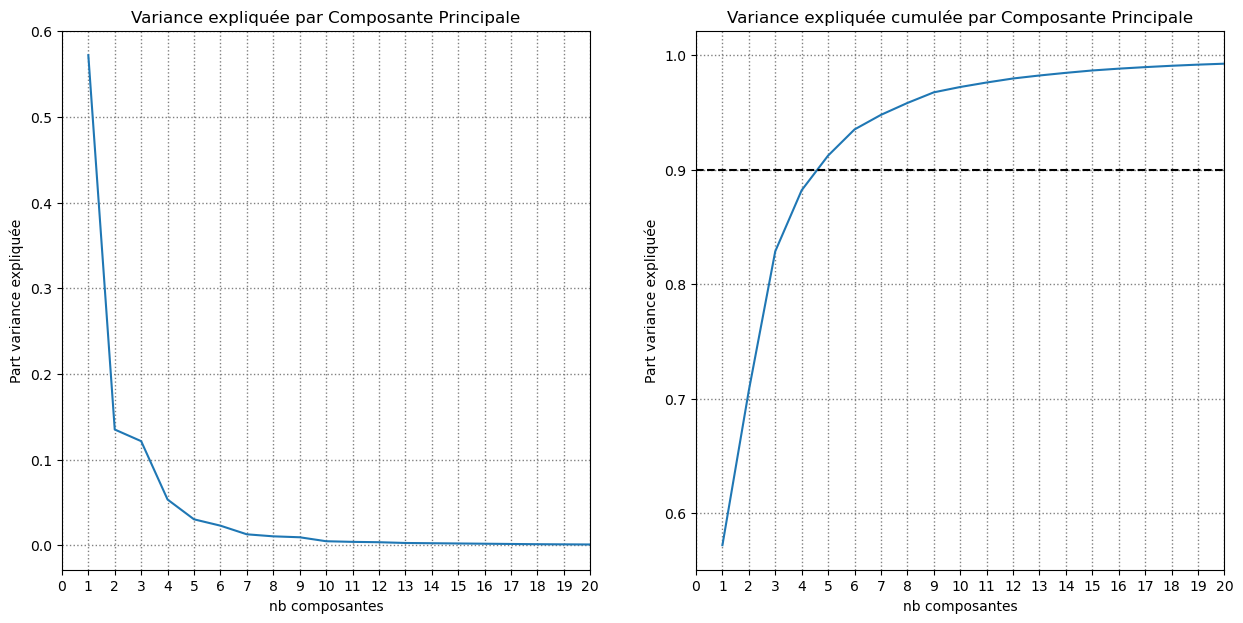

Part de la variance expliquée conservée pour 10 composantes : 97.23%
regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

20
base :  2. Détourée source :  1. Intensité


In [34]:
### 5. Test modèles sur images détourées : source de données Intensité (ML_01)

## Import fichier
ML_file_path = os.path.join(const.DATA_ML_PATH, 'ML_rep100_BGR_det.csv')
df_rep100_BGR_det = pd.read_csv(ML_file_path, header=0, index_col=0, sep=',')

## Sélection des 10 classes testées pour K-means
df_rep100_BGR_det = df_rep100_BGR_det[df_rep100_BGR_det['classe'].isin(classes)]

print(df_rep100_BGR_det.shape)
print(np.unique(df_rep100_BGR_det['classe']))

## Traitements "classiques"

# Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# + normalisation
X_train, y_train, X_test, y_test, X_valid, y_valid = sep_data(df_rep100_BGR_det, norm=True)

# Recherche et suppression des variables de variance nulle
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).sup_var_null()

# Visualisation ACP
display(Reduc_feat(X_train, [X_train, X_test, X_valid]).print_acp(20))

# Éxécution ACP
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).exe_acp(10)

## Modélisation
ds_ML1 = [X_train, X_test, X_valid, y_train, y_test, y_valid]

classes = np.unique(ds_ML1[3].values)

res_log, res_rfc, res_bag, res_xgb = Models(ds_ML1).classif()
res_classif = [res_log, res_rfc, res_bag, res_xgb]

mdl_classif = ['Reg Logistique', 'Random Forest', 'Bagging', 'XGBoost']

base = '2. Détourée'
source = '1. Intensité'

# liste des classes sélectionnées
classe_sel = ''
for i, cl in enumerate(classes):
    if i == 0:
        classe_sel = cl
    else:
        classe_sel = classe_sel + ', ' + cl

for mdl, res in zip(mdl_classif, res_classif):
    # Enregistrement du contexte du modèle
    res_mdl = []
    res_mdl.append(base)
    res_mdl.append(source)
    res_mdl.append(len(classes))
    res_mdl.append(classe_sel)
    res_mdl.append(mdl)
    # Enregistrement des paramètres et du score du modèle
    param = list(res[mdl].values())[0]
    param = f'{param}'                  # Passage en string
    param = re.sub('\s+', ' ', param)   # Suppression des tabulsations, retour à la ligne, ...
    res_score = list(res[mdl].values())[1]
    res_mdl.append(param)
    res_mdl.append(res_score)
    # Ajout à la liste finale
    res_ml.append(res_mdl)

print(len(res_ml))
print("base : ", base, "source : ", source)

(1600, 483)
['ALPINE CHOUGH' 'BLACK VENTED SHEARWATER' 'BROWN THRASHER'
 'CERULEAN WARBLER' 'FIRE TAILLED MYZORNIS' 'INCA TERN' 'INDIAN PITTA'
 'JOCOTOCO ANTPITTA' 'PARAKETT AUKLET' 'VEERY']
Quantité par échantillon : 
 echantillon
train    1120
test      240
valid     240
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


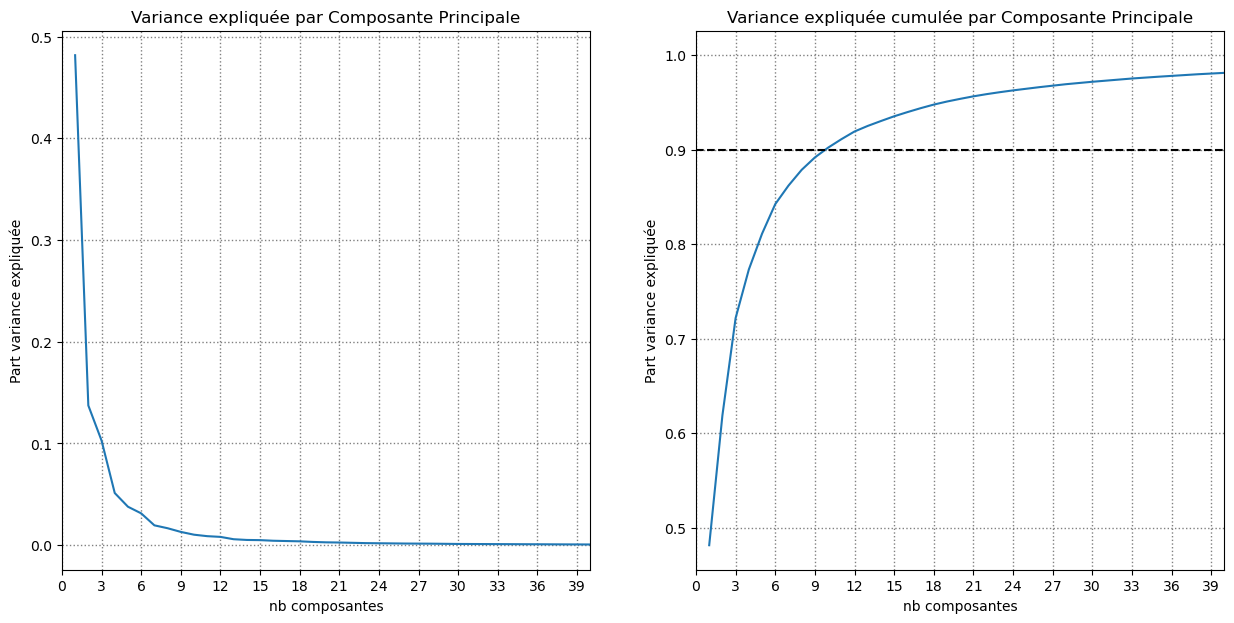

Part de la variance expliquée conservée pour 24 composantes : 96.28%
regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

24


In [35]:
### 6. Test modèles sur images détourées : source de données Palette couleurs (ML_02)

## Import fichier
ML_file_path = os.path.join(const.DATA_ML_PATH, 'ML_maincolors20_det.csv')
df_maincolors_det = pd.read_csv(ML_file_path, header=0, index_col=0, sep=',')

## Sélection des 10 classes testées pour K-means
df_maincolors_det = df_maincolors_det[df_maincolors_det['classe'].isin(classes)]

print(df_maincolors_det.shape)
print(np.unique(df_maincolors_det['classe']))

## Traitements "classiques"

# Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# + normalisation
X_train, y_train, X_test, y_test, X_valid, y_valid = sep_data(df_maincolors_det, norm=True)

# Recherche et suppression des variables de variance nulle
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).sup_var_null()

# Visualisation ACP
display(Reduc_feat(X_train, [X_train, X_test, X_valid]).print_acp(40))

# Éxécution ACP
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).exe_acp(24)

## Modélisation
ds_ML2 = [X_train, X_test, X_valid, y_train, y_test, y_valid]

classes = np.unique(ds_ML2[3].values)

res_log, res_rfc, res_bag, res_xgb = Models(ds_ML2).classif()
res_classif = [res_log, res_rfc, res_bag, res_xgb]

mdl_classif = ['Reg Logistique', 'Random Forest', 'Bagging', 'XGBoost']

base = '2. Détourée'
source = '2. Couleurs'

# liste des classes sélectionnées
classe_sel = ''
for i, cl in enumerate(classes):
    if i == 0:
        classe_sel = cl
    else:
        classe_sel = classe_sel + ', ' + cl

for mdl, res in zip(mdl_classif, res_classif):
    # Enregistrement du contexte du modèle
    res_mdl = []
    res_mdl.append(base)
    res_mdl.append(source)
    res_mdl.append(len(classes))
    res_mdl.append(classe_sel)
    res_mdl.append(mdl)
    # Enregistrement des paramètres et du score du modèle
    param = list(res[mdl].values())[0]
    param = f'{param}'                  # Passage en string
    param = re.sub('\s+', ' ', param)   # Suppression des tabulsations, retour à la ligne, ...
    res_score = list(res[mdl].values())[1]
    res_mdl.append(param)
    res_mdl.append(res_score)
    # Ajout à la liste finale
    res_ml.append(res_mdl)

print(len(res_ml))

df_res_ml = pd.DataFrame(res_ml, columns=['Dataset', 'Source', 'Nb_classes_pred', 
                                          'Classes_sel', 'Modele', 'Paramètres', 'Accuracy'])

df_res_ml.to_csv(ML_file_path_res, sep=';', header=True, index=False, encoding='ANSI')

,Dataset,Source,Accuracy
0,1. Originale,1. Intensité,0.604
1,1. Originale,2. Couleurs,0.621
2,1. Originale,3. K-means,0.533
3,2. Détourée,1. Intensité,0.717
4,2. Détourée,2. Couleurs,0.825
5,2. Détourée,3. K-means,0.675


(6, 3)

[0.717, 0.825, 0.675]
2


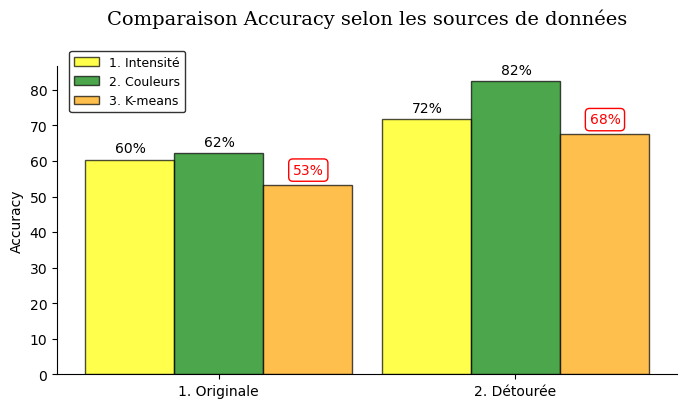

In [36]:
# Meilleur modèle obtenu selon le dataset (original / détouré) et la source de données (K-means, intensité ou couleurs)
res_mdl = df_res_ml.groupby(['Dataset', 'Source'], as_index=False)['Accuracy'].max()

display(res_mdl, res_mdl.shape)
x = 1
print([res_mdl.iloc[x*3, 2], res_mdl.iloc[1 + x*3, 2], res_mdl.iloc[2 + x*3, 2]])
print(len(res_mdl['Dataset'].unique()))

# Création des graphiques
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)
coul = ['yellow','green','orange']

# Plot bar 
barWidth = 0.3 
for x in range(len(res_mdl['Source'].unique())):
    axe = [i + barWidth * (x - 1) for i in range(len(res_mdl['Dataset'].unique()))]
    ax1.bar(axe, [res_mdl.iloc[x, 2]*100, res_mdl.iloc[x+3, 2]*100], 
            color=coul[x], width=barWidth, 
            edgecolor='black', label=res_mdl.iloc[x, 1], alpha =0.7)
    # Ajout des valeurs sur les bars
    for index, value in zip(axe, [res_mdl.iloc[x, 2]*100, res_mdl.iloc[x+3, 2]*100]):
        if x == 2:
             ax1.text(index - 0.05, value + 3,
                         str(f'{int(round(value ,0))}%'), color='red', 
                         bbox=dict(boxstyle='round', fc="w", ec="r"))
        else:
            ax1.text(index - 0.05, value + 2,
                         str(f'{int(round(value ,0))}%'))
        # test = AnnotationBbox(str(f'{int(round(value*100 ,0))}%'), [index - 0.05, value + 0.02])
        # ax.add_artist(test)
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0.0, 2, 1))
ax1.set_xticklabels(res_mdl['Dataset'].unique())
# ax2.set_xticklabels(['','', 'Minimum', '', 'Moyenne', '', 'Maximum'])
ax1.legend(loc=(0.02, 0.85), edgecolor='black', fontsize=9)
titre = ax1.set_title("Comparaison Accuracy selon les sources de données", pad=30)
titre.set(color="black", fontsize="14", fontfamily="serif")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.show()

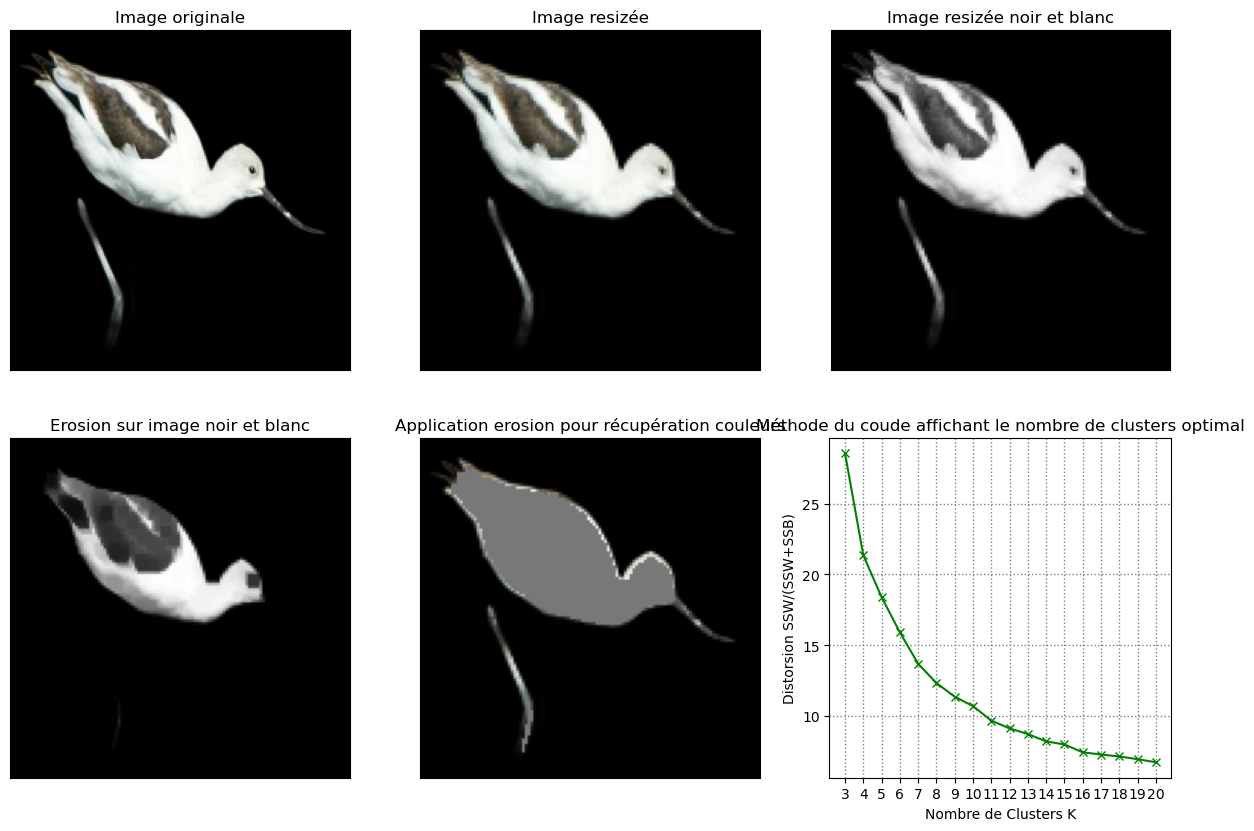

In [41]:
### Test pour fixer nombre de couleurs à conserver pour images détourées

from scipy.spatial.distance import cdist

## Images "spéciales" (avec valeurs manquantes)
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BULWERS PHEASANT\\55.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\LAUGHING GULL\\209.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\WALL CREAPER\\147.JPG')

## Images pas ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN PIED HORNBILL\\164.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\45.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ASIAN CRESTED IBIS\\126.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ALPINE CHOUGH\\42.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BUSH TURKEY\\17.JPG')

## Images ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN FLAMINGO\\27.JPG')
img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\69.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\1.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\134.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\CROW\\20.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN EMERALD CUCKOO\\114.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\YELLOW BREASTED CHAT\\60.JPG')


# Taille image resizée
img_width = 120
img_height = 120

# seuil érosion
seuil_ero = 2

# Nb de couleurs souhaitées dans palette
nb_colors = 20

# Affichage image originale
plt.figure(figsize = (15,15))
plt.subplot(331)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

# Resize image et affichage
img_color = cv2.resize(img, dsize = (img_width,img_height)) 

plt.subplot(332)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image resizée')

# Passage en noir et blanc et affichage
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
plt.subplot(333)
plt.imshow(img_gray, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Image resizée noir et blanc')

# Erosion et affichage
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(img_gray, kernel)
plt.subplot(334)
plt.imshow(erosion, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Erosion sur image noir et blanc')

erosion_gray = erosion.reshape(img_width*img_height, 1)
erosion = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
erosion = erosion.reshape(img_width*img_height, 3)

# Application erosion à image en noir et blanc
img_sort_gray = img_gray.reshape(img_width*img_height, 1)
img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]

# Test découpage et ajustement seuil si besoin
decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors), axis=0))

# Ajustement seuil érosion (5 maximum)
# print(seuil_ero)
while len(np.unique(decoup)) <= nb_colors and seuil_ero<5:
    seuil_ero += 1
    img_sort_gray = img_gray.reshape(img_width*img_height, 1)
    img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]
    decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors), axis=0))
    # print(seuil_ero)

# Exlusion des pixels totalement blancs (problème image)
erosion[(erosion[:,0] > (255 - seuil_ero)) & 
        (erosion[:,1] > (255 - seuil_ero)) & 
        (erosion[:,2] > (255 - seuil_ero))] = 0

# Application érosion sur image couleur
img_sort_color = img_color.reshape(img_width*img_height, 3).copy()

img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                (erosion[:,1] > seuil_ero) |
                                (erosion[:,2] > seuil_ero)]

# Application érosion sur image couleur pour affichage
img_color_sel = img_color.reshape(img_width*img_height, 3).copy()
img_color_sel[(erosion[:,0] > seuil_ero) | (erosion[:,1] > seuil_ero) | (erosion[:,2] > seuil_ero)] = 120
img_color_sel = img_color_sel.reshape(img_width, img_height, 3)

plt.subplot(335)
plt.imshow(cv2.cvtColor(img_color_sel, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Application erosion pour récupération couleurs')

distorsions = []

for i in range(3, 21):
    # Algorithme de K-means
    cluster = KMeans(n_clusters = i)
    cluster.fit(img_sort_color)

    distorsions.append(sum(np.min(cdist(img_sort_color, cluster.cluster_centers_, 'euclidean'), axis=1)) 
                       / np.size(img_sort_color, axis = 0))

# Graphique des distorsions
plt.subplot(336)
plt.plot(range(3, 21, 1), distorsions, 'gx-')
plt.xticks(range(3, 21, 1))
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Méthode du coude affichant le nombre de clusters optimal')
plt.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
plt.show()

152 610


,R_mean,R_std,R_median,R_q1,R_q3,R_iqr,G_mean,G_std,G_median,G_q1,...,B_q1,B_q3,B_iqr,Gray_mean,Gray_std,Gray_median,Gray_q1,Gray_q3,Gray_iqr,poids_%
Color,,,,,,,,,,,,,,,,,,,,,
C1,46.6,5.7,46.0,42.8,50.0,7.2,61.8,6.0,62.0,57.0,...,32.0,40.0,8.0,54.3,4.0,55.0,51.0,57.0,6.0,12.7
C2,59.7,6.9,59.0,54.2,65.0,10.8,74.3,6.4,74.0,70.0,...,44.0,51.0,7.0,66.9,4.3,67.0,63.0,70.8,7.8,10.8
C3,70.1,6.0,70.0,66.0,74.0,8.0,93.9,6.9,95.0,89.0,...,55.0,62.0,7.0,82.7,4.4,83.0,79.0,86.0,7.0,10.0
C4,66.4,5.6,66.0,62.0,71.0,9.0,99.0,5.2,99.0,95.0,...,37.0,43.0,6.0,82.5,4.3,83.0,79.0,86.0,7.0,9.9
C5,38.4,6.4,38.0,34.0,42.0,8.0,42.8,7.6,43.0,38.0,...,21.0,28.0,7.0,39.4,5.2,39.0,35.0,44.0,9.0,9.4
C6,79.7,4.7,80.0,76.0,83.0,7.0,110.2,5.1,110.0,106.0,...,48.0,56.0,8.0,94.3,4.1,94.0,91.0,97.0,6.0,8.3
C7,86.4,7.0,86.0,82.0,90.0,8.0,110.4,7.1,110.0,106.0,...,63.0,72.0,9.0,98.5,4.8,98.0,95.0,102.0,7.0,7.4
C8,71.2,4.4,72.0,68.0,74.0,6.0,106.3,4.5,106.0,104.0,...,16.0,27.0,11.0,86.1,4.0,86.0,84.0,89.0,5.0,7.2
C9,51.6,4.8,51.0,48.0,55.0,7.0,80.6,6.4,80.0,76.0,...,24.0,33.0,9.0,66.0,5.0,66.0,62.0,70.0,8.0,5.4


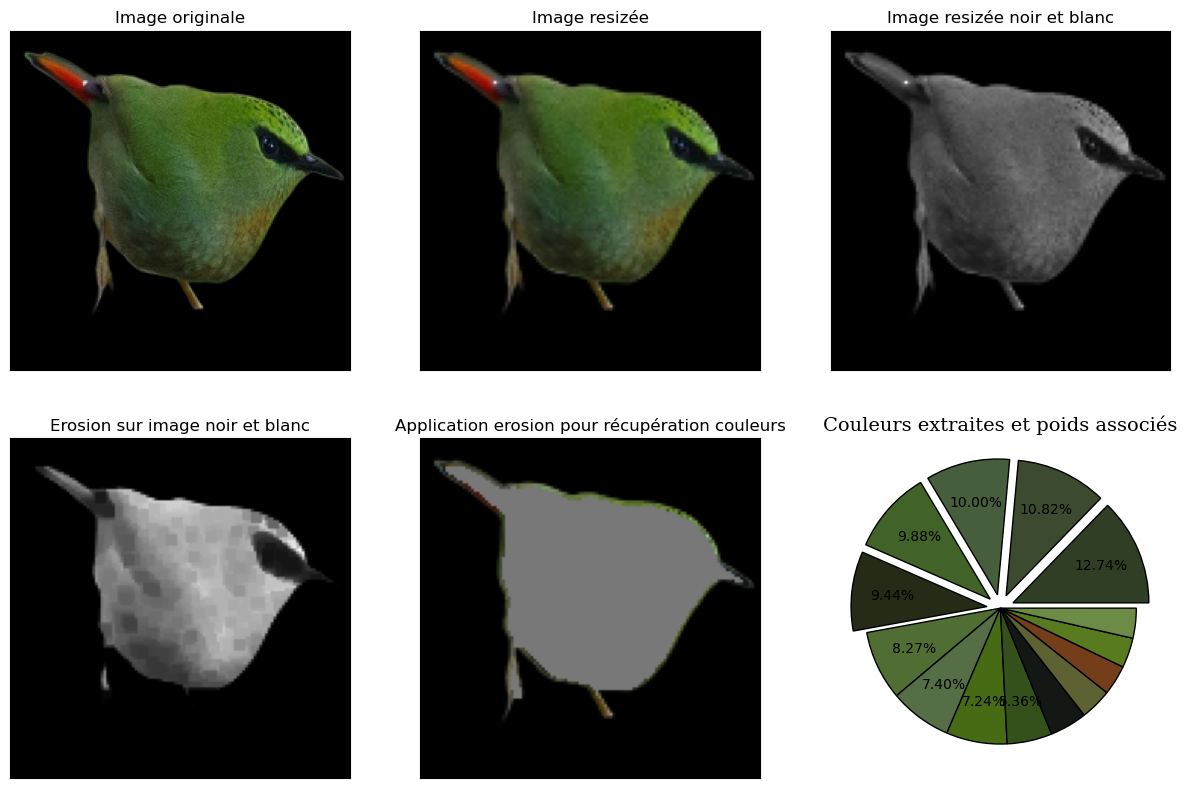

In [43]:
### Test avec KMeansConstrained

from k_means_constrained import KMeansConstrained

## Images "spéciales" (avec valeurs manquantes)
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BULWERS PHEASANT\\55.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\LAUGHING GULL\\209.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\WALL CREAPER\\147.JPG')

## Images pas ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN PIED HORNBILL\\164.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\45.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ASIAN CRESTED IBIS\\126.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ALPINE CHOUGH\\42.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BUSH TURKEY\\17.JPG')

## Images ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\valid\\FIRE TAILLED MYZORNIS\\147.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN FLAMINGO\\27.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\69.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\1.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\134.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\CROW\\20.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN EMERALD CUCKOO\\114.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\YELLOW BREASTED CHAT\\60.JPG')


# Taille image resizée
img_width = 120
img_height = 120

# seuil érosion
seuil_ero = 2

# Nb de couleurs souhaitées dans palette
nb_colors_clean = 20
nb_colors = 14

# Affichage image originale
plt.figure(figsize = (15,15))
plt.subplot(331)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

# Resize image et affichage
img_color = cv2.resize(img, dsize = (img_width,img_height)) 

plt.subplot(332)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image resizée')

# Passage en noir et blanc et affichage
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
plt.subplot(333)
plt.imshow(img_gray, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Image resizée noir et blanc')

# Erosion et affichage
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(img_gray, kernel)
plt.subplot(334)
plt.imshow(erosion, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Erosion sur image noir et blanc')

erosion_gray = erosion.reshape(img_width*img_height, 1)
erosion = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
erosion = erosion.reshape(img_width*img_height, 3)

# Application erosion à image en noir et blanc
img_sort_gray = img_gray.reshape(img_width*img_height, 1)
img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]

# Test découpage et ajustement seuil si besoin
decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors_clean), axis=0))

# Ajustement seuil érosion (5 maximum)
# print(seuil_ero)
while len(np.unique(decoup)) <= nb_colors_clean and seuil_ero<5:
    seuil_ero += 1
    img_sort_gray = img_gray.reshape(img_width*img_height, 1)
    img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]
    decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors_clean), axis=0))
    # print(seuil_ero)

# Exlusion des pixels totalement blancs (problème image)
erosion[(erosion[:,0] > (255 - seuil_ero)) & 
        (erosion[:,1] > (255 - seuil_ero)) & 
        (erosion[:,2] > (255 - seuil_ero))] = 0

# Application érosion sur image couleur
img_sort_color = img_color.reshape(img_width*img_height, 3).copy()

img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                (erosion[:,1] > seuil_ero) |
                                (erosion[:,2] > seuil_ero)]

# Application érosion sur image couleur pour affichage
img_color_sel = img_color.reshape(img_width*img_height, 3).copy()
img_color_sel[(erosion[:,0] > seuil_ero) | (erosion[:,1] > seuil_ero) | (erosion[:,2] > seuil_ero)] = 120
img_color_sel = img_color_sel.reshape(img_width, img_height, 3)

plt.subplot(335)
plt.imshow(cv2.cvtColor(img_color_sel, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Application erosion pour récupération couleurs')

# Algorithme de K-means
# Définition taille minimum cluster
size_min = int(len(img_sort_color) * ((1/nb_colors)/2))
size_max = int(len(img_sort_color) * ((1/nb_colors)*2))
print(size_min, size_max)

kmeans = KMeansConstrained(n_clusters = nb_colors, size_min=size_min, size_max=size_max)
kmeans.fit(img_sort_color)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# print(type(labels), labels, np.unique(labels), labels.shape)

labels.shape = (len(labels), 1)
decoup_source = np.concatenate([img_sort_color, labels], axis = 1)

# Passage en DataFrame
df_img_gray = pd.DataFrame(img_sort_gray, columns=['Gray'])
df_img_color = pd.DataFrame(decoup_source, columns=['B','G','R','Decoup'])

df_img = pd.concat([df_img_gray, df_img_color], axis=1)

# Calcul des indicateurs
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def iqr(x):
    return q3(x) - q1(x) 

calculs = {'R':['mean', 'std', 'median', q1, q3, iqr],
           'G':['mean', 'std', 'median', q1, q3, iqr],
           'B':['mean', 'std', 'median', q1, q3, iqr],
           'Gray':['mean', 'std', 'median', q1, q3, iqr],
           'Decoup':'count'}

df_img_sort = df_img.groupby('Decoup', as_index=False).agg(calculs).round(1)

# df_img_sort.columns = ['_'.join(col) for col in df_img_sort.columns.values]
df_img_sort = df_img_sort.set_axis(df_img_sort.columns.map('_'.join), axis=1)

df_img_sort = df_img_sort.sort_values(by='Decoup_count', ascending=False)
df_img_sort['Color'] = [f'C{i}' for i in range(1, nb_colors + 1)]

colors = []
explode = []
for i in range(0, nb_colors):
    nt = (df_img_sort.iloc[i,0] / 255, df_img_sort.iloc[i,6] / 255, df_img_sort.iloc[i,12] / 255)
    colors.append(nt)
    if i <= 4:
        explode.append(0.1)
    else:
        explode.append(0)

# print(colors[1], type(colors[1]))

ax = plt.subplot(336)
ax.pie(df_img_sort['Decoup_count'], # labels=df_img_sort['Color'],
        colors=colors, 
        explode=explode,
        labeldistance=0.7,
        autopct=lambda v: f'{v:.2f}%' if v > 5 else None,
        pctdistance=0.7,
        wedgeprops={"edgecolor":"k",'linewidth': 1})
titre = ax.set_title("Couleurs extraites et poids associés")
titre.set(color="black", fontsize="14", fontfamily="serif")

# Passage des poids en %
df_img_sort['poids_%'] = round((df_img_sort['Decoup_count'] / df_img_sort['Decoup_count'].sum())*100, 1)
df_img_sort = df_img_sort.drop('Decoup_count', axis=1)
df_img_sort = df_img_sort.set_index('Color')

# df_img_sort.to_csv('..\\data\\data_ML\\test_kmeans.csv', sep=',', header=True, index=True)
display(df_img_sort)

rep_color_img = []
# # Passage des informations en colonne pour chaque couleur
for i in range(0, df_img_sort.shape[0]):
#     # print(list(df_img_sort.iloc[i,-20:]))
    if i == 0:
        rep_color_img = list(df_img_sort.iloc[i,-25:])
    else:
        rep_color_img.extend(list(df_img_sort.iloc[i,-25:]))